# Notebook 2: Wrangling & Feature Engineering

**Phases 4-5:** Data Wrangling & Transformation, Feature Engineering & Aggregation

**Dataset:** NYC Taxi Trip Dataset (continuing from Notebook 1)

**Focus:** Transforming and enriching data - merging datasets, working with datetime data, reshaping, and creating features for modeling.

---

## Phase 4: Data Wrangling & Transformation

### Learning Objectives

- Merge and join multiple datasets
- Handle datetime columns and set datetime index
- Extract time-based features
- Reshape data for analysis
- Work with indexes

### Step 1: Load Cleaned Data from Previous Notebook

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import os

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Load cleaned data from Notebook 1
df = pd.read_csv('../output/01_cleaned_taxi_data.csv')

display(Markdown(f"""
### 📂 Data Loaded

| Metric | Value |
|--------|-------|
| **Total trips** | {len(df):,} |
| **Date range** | {df['pickup_datetime'].min()} to {df['pickup_datetime'].max()} |
"""))

# Check if location IDs are available (they should be if using real NYC TLC data)
if 'PULocationID' in df.columns and 'DOLocationID' in df.columns:
    display(Markdown(f"✅ **Location IDs found:** {df['PULocationID'].nunique()} unique pickup zones, {df['DOLocationID'].nunique()} unique dropoff zones"))
else:
    display(Markdown("⚠️ *Note: PULocationID/DOLocationID not found - zone lookup will be limited*"))


### 📂 Data Loaded

| Metric | Value |
|--------|-------|
| **Total trips** | 2,879,404 |
| **Date range** | 2022-10-25 00:42:10 to 2023-02-01 00:56:53 |


✅ **Location IDs found:** 254 unique pickup zones, 261 unique dropoff zones

### Step 2: Convert to Datetime and Set Datetime Index

In [2]:
# Convert datetime columns
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Recalculate trip_duration if needed
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

# Set pickup_datetime as index for datetime-based operations
df_ts = df.set_index('pickup_datetime').sort_index()

display(Markdown(f"""
### ✅ Datetime Index Set

| Metric | Value |
|--------|-------|
| **Shape** | {df_ts.shape[0]:,} rows × {df_ts.shape[1]} columns |
| **Index range** | {df_ts.index.min()} to {df_ts.index.max()} |
"""))

display(Markdown("**Preview:**"))
display(Markdown(df_ts.head().to_markdown()))


### ✅ Datetime Index Set

| Metric | Value |
|--------|-------|
| **Shape** | 2,879,404 rows × 20 columns |
| **Index range** | 2022-10-25 00:42:10 to 2023-02-01 00:56:53 |


**Preview:**

| pickup_datetime     |   VendorID | dropoff_datetime    |   passenger_count |   trip_distance |   RatecodeID | store_and_fwd_flag   |   PULocationID |   DOLocationID |   payment_type |   fare_amount |   extra |   mta_tax |   tip_amount |   tolls_amount |   improvement_surcharge |   total_amount |   congestion_surcharge |   airport_fee |   trip_duration | pickup_date   |
|:--------------------|-----------:|:--------------------|------------------:|----------------:|-------------:|:---------------------|---------------:|---------------:|---------------:|--------------:|--------:|----------:|-------------:|---------------:|------------------------:|---------------:|-----------------------:|--------------:|----------------:|:--------------|
| 2022-10-25 00:42:10 |          2 | 2022-10-25 00:44:22 |                 1 |            0.97 |            1 | N                    |            132 |            132 |              2 |           4.5 |       0 |       0.5 |         0    |              0 |                     0.3 |           5    |                      0 |          1.25 |       2.2       | 2022-10-25    |
| 2022-10-25 00:59:02 |          2 | 2022-10-25 01:09:02 |                 1 |            2.33 |            1 | N                    |            265 |            265 |              2 |          10   |       0 |       0.5 |         0    |              0 |                     0.3 |          10.5  |                      0 |          0    |      10         | 2022-10-25    |
| 2022-10-25 03:45:46 |          2 | 2022-10-25 03:45:50 |                 1 |            0.02 |            5 | N                    |              1 |              1 |              1 |         115   |       0 |       0   |         5    |              0 |                     0.3 |         120.5  |                      0 |          0    |       0.0666667 | 2022-10-25    |
| 2022-10-25 07:48:15 |          2 | 2022-10-25 07:48:18 |                 2 |            0.76 |            5 | N                    |            132 |            264 |              1 |          78   |       0 |       0.5 |        15.76 |              0 |                     0.3 |          94.26 |                      0 |          0    |       0.05      | 2022-10-25    |
| 2022-10-25 09:06:23 |          2 | 2022-10-25 09:21:36 |                 1 |            6.48 |            1 | N                    |            132 |             38 |              2 |          19.5 |       0 |       0.5 |         0    |              0 |                     0.3 |          20    |                      0 |          1.25 |      15.2167    | 2022-10-25    |

### Step 3: Extract Time-Based Features

**Why extract time-based features?**

- **Temporal patterns:** Hour, day of week, and month reveal important patterns (rush hours, weekends, seasons)
- **Modeling:** Time features are often strong predictors (e.g., fare varies by time of day)
- **Analysis:** Enable grouping and aggregation by time periods

**What time features to extract?**

- **Hour (0-23):** Captures daily patterns (morning rush, lunch, evening)
- **Day of week (0-6):** Captures weekly patterns (weekdays vs weekends)
- **Month (1-12):** Captures seasonal patterns
- **Derived features:** Weekend flag, time-of-day categories, etc.

In [3]:
# Extract various time-based features from the datetime index
df_ts['hour'] = df_ts.index.hour
df_ts['day_of_week'] = df_ts.index.dayofweek  # 0=Monday, 6=Sunday
df_ts['day_name'] = df_ts.index.day_name()
df_ts['month'] = df_ts.index.month
df_ts['month_name'] = df_ts.index.month_name()
df_ts['year'] = df_ts.index.year
df_ts['is_weekend'] = df_ts['day_of_week'].isin([5, 6]).astype(int)

# Time-of-day categorization constants
# These boundaries capture typical NYC activity patterns
MORNING_START = 5    # Rush hour begins
AFTERNOON_START = 12  # Lunch and midday
EVENING_START = 17   # Evening rush hour begins
NIGHT_START = 21     # Late night/early morning

def get_time_of_day(hour):
    """
    Categorize hour into time-of-day period based on NYC patterns.

    - Morning (5-11): Morning rush hour, breakfast
    - Afternoon (12-16): Lunch, midday activity
    - Evening (17-20): Evening rush hour, dinner
    - Night (21-4): Late night, reduced activity
    """
    if MORNING_START <= hour < AFTERNOON_START:
        return 'Morning'
    elif AFTERNOON_START <= hour < EVENING_START:
        return 'Afternoon'
    elif EVENING_START <= hour < NIGHT_START:
        return 'Evening'
    else:
        return 'Night'

df_ts['time_of_day'] = df_ts['hour'].apply(get_time_of_day)

display(Markdown("### ⏰ Time-Based Features Extracted"))
display(Markdown(df_ts[['hour', 'day_of_week', 'day_name', 'month', 'is_weekend', 'time_of_day']].head(10).to_markdown()))

### ⏰ Time-Based Features Extracted

| pickup_datetime     |   hour |   day_of_week | day_name   |   month |   is_weekend | time_of_day   |
|:--------------------|-------:|--------------:|:-----------|--------:|-------------:|:--------------|
| 2022-10-25 00:42:10 |      0 |             1 | Tuesday    |      10 |            0 | Night         |
| 2022-10-25 00:59:02 |      0 |             1 | Tuesday    |      10 |            0 | Night         |
| 2022-10-25 03:45:46 |      3 |             1 | Tuesday    |      10 |            0 | Night         |
| 2022-10-25 07:48:15 |      7 |             1 | Tuesday    |      10 |            0 | Morning       |
| 2022-10-25 09:06:23 |      9 |             1 | Tuesday    |      10 |            0 | Morning       |
| 2022-10-25 13:03:37 |     13 |             1 | Tuesday    |      10 |            0 | Afternoon     |
| 2022-12-31 14:24:54 |     14 |             5 | Saturday   |      12 |            1 | Afternoon     |
| 2022-12-31 14:39:43 |     14 |             5 | Saturday   |      12 |            1 | Afternoon     |
| 2022-12-31 15:14:12 |     15 |             5 | Saturday   |      12 |            1 | Afternoon     |
| 2022-12-31 22:02:51 |     22 |             5 | Saturday   |      12 |            1 | Night         |

### Step 4: Merge with Additional Data (Zone Lookup Table)

**Note:** NYC TLC data includes `PULocationID` and `DOLocationID` columns. We'll load the official NYC Taxi Zone lookup table (downloaded by `download_data.sh`) and merge it with the trip data to add zone names and boroughs.

In [4]:
# Verify that location IDs are present in the data
# Real NYC TLC data includes PULocationID and DOLocationID columns
if 'PULocationID' not in df_ts.columns or 'DOLocationID' not in df_ts.columns:
    raise ValueError("PULocationID and DOLocationID columns not found in data. This is required for zone lookup merge.")

# Load official NYC Taxi Zone Lookup Table
# This file is downloaded by download_data.sh and contains all 265 zones with official names
zone_lookup_file = 'data/taxi_zone_lookup.csv'

if not os.path.exists(zone_lookup_file):
    display(Markdown("""
### ❌ Zone Lookup File Not Found

Please run `download_data.sh` to download the zone lookup file:
```bash
chmod +x download_data.sh
./download_data.sh
```
"""))
    raise FileNotFoundError(f"Zone lookup file not found: {zone_lookup_file}. Run download_data.sh first.")

# Load official zone lookup file
zone_lookup = pd.read_csv(zone_lookup_file)
# Rename columns to match our merge needs
# Drop 'service_zone' to avoid duplicate columns when merging pickup and dropoff
zone_lookup = zone_lookup.rename(columns={'Zone': 'zone_name'}).drop(columns=['service_zone'], errors='ignore')

display(Markdown(f"✅ **Loaded official zone lookup:** {len(zone_lookup)} zones"))
display(Markdown(f"**Columns:** `{list(zone_lookup.columns)}`"))
display(Markdown("**Sample zones:**"))
display(Markdown(zone_lookup[['LocationID', 'Borough', 'zone_name']].head(5).to_markdown(index=False)))

# Use actual location IDs from the real NYC TLC data
# Real data includes PULocationID and DOLocationID columns
df_ts_reset = df_ts.reset_index()

if 'PULocationID' in df_ts_reset.columns and 'DOLocationID' in df_ts_reset.columns:
    # Rename to match zone_lookup column name for merging
    df_ts_reset = df_ts_reset.rename(columns={'PULocationID': 'pickup_zone_id', 'DOLocationID': 'dropoff_zone_id'})
    display(Markdown(f"""
✅ **Using real location IDs from NYC TLC data**
- **Pickup zones:** {df_ts_reset['pickup_zone_id'].nunique()} unique
- **Dropoff zones:** {df_ts_reset['dropoff_zone_id'].nunique()} unique
"""))
else:
    # This should never execute - we check for PULocationID/DOLocationID above and raise ValueError if missing
    # If we somehow get here, we can't do zone assignment without location IDs
    raise ValueError("PULocationID/DOLocationID columns are required but not found. This should not happen with real NYC TLC data.")

# Merge pickup zone information using LEFT JOIN
# LEFT JOIN keeps all rows from left DataFrame (df_ts), adds matching data from right (zone_lookup)
# This is the most common join type - we want all trips, even if zone info is missing
# IMPORTANT: Reset index before merge, then set it back to preserve DatetimeIndex

if 'pickup_zone_id' in df_ts_reset.columns:
    # Merge pickup zone information using LEFT JOIN
    df_ts_reset = df_ts_reset.merge(
        zone_lookup.rename(columns={'LocationID': 'pickup_zone_id', 'zone_name': 'pickup_zone_name', 'Borough': 'pickup_borough'}),
        on='pickup_zone_id',
        how='left'  # LEFT JOIN: keep all trips, add zone info where available
    )
    
    # Merge dropoff zone information
    df_ts_reset = df_ts_reset.merge(
        zone_lookup.rename(columns={'LocationID': 'dropoff_zone_id', 'zone_name': 'dropoff_zone_name', 'Borough': 'dropoff_borough'}),
        on='dropoff_zone_id',
        how='left'  # LEFT JOIN: keep all trips
    )
    
    display(Markdown(f"""
### ✅ Zone Information Merged

| Metric | Value |
|--------|-------|
| **Total columns** | {df_ts_reset.shape[1]} |
| **Zones matched** | {df_ts_reset['pickup_zone_name'].notna().sum():,} / {len(df_ts_reset):,} trips |
"""))
    if 'pickup_zone_name' in df_ts_reset.columns:
        display(Markdown("**Sample zone information:**"))
        display(df_ts_reset[['pickup_zone_name', 'pickup_borough', 'dropoff_zone_name', 'dropoff_borough']].head(10))
else:
    display(Markdown("⚠️ *Zone merge skipped - location IDs not available in data*"))

# Set datetime index back
df_ts = df_ts_reset.set_index('pickup_datetime').sort_index()

# Demonstrate other join types (for educational purposes)
display(Markdown("# 🔗 Join Type Examples (Educational)"))

# Create example DataFrames to demonstrate join types
left_df = pd.DataFrame({'key': [1, 2, 3, 4], 'left_value': ['A', 'B', 'C', 'D']})
right_df = pd.DataFrame({'key': [2, 3, 4, 5], 'right_value': ['X', 'Y', 'Z', 'W']})

display(Markdown(f"""
**Left DataFrame:**

{left_df.to_markdown(index=False)}

**Right DataFrame:**

{right_df.to_markdown(index=False)}
"""))

# INNER JOIN: Only rows with matching keys in both DataFrames
inner_result = pd.merge(left_df, right_df, on='key', how='inner')
display(Markdown(f"""
### INNER JOIN *(only matching keys)*

{inner_result.to_markdown(index=False)}

> Keys 2, 3, 4 exist in **both** tables → 3 rows returned
"""))

# LEFT JOIN: All rows from left, matching from right
left_result = pd.merge(left_df, right_df, on='key', how='left')
display(Markdown(f"""
### LEFT JOIN *(all from left, matching from right)*

{left_result.to_markdown(index=False)}

> All 4 keys from left table kept; key 1 has no match → `NaN` for right_value
"""))

# RIGHT JOIN: All rows from right, matching from left
right_result = pd.merge(left_df, right_df, on='key', how='right')
display(Markdown(f"""
### RIGHT JOIN *(all from right, matching from left)*

{right_result.to_markdown(index=False)}

> All 4 keys from right table kept; key 5 has no match → `NaN` for left_value
"""))

# OUTER JOIN: All rows from both DataFrames
outer_result = pd.merge(left_df, right_df, on='key', how='outer')
display(Markdown(f"""
### OUTER JOIN *(all rows from both)*

{outer_result.to_markdown(index=False)}

> All keys from both tables: 1-5. Keys 1 and 5 have `NaN` where no match exists
"""))

✅ **Loaded official zone lookup:** 265 zones

**Columns:** `['LocationID', 'Borough', 'zone_name']`

**Sample zones:**

|   LocationID | Borough       | zone_name               |
|-------------:|:--------------|:------------------------|
|            1 | EWR           | Newark Airport          |
|            2 | Queens        | Jamaica Bay             |
|            3 | Bronx         | Allerton/Pelham Gardens |
|            4 | Manhattan     | Alphabet City           |
|            5 | Staten Island | Arden Heights           |


✅ **Using real location IDs from NYC TLC data**
- **Pickup zones:** 254 unique
- **Dropoff zones:** 261 unique



### ✅ Zone Information Merged

| Metric | Value |
|--------|-------|
| **Total columns** | 33 |
| **Zones matched** | 2,842,049 / 2,879,404 trips |


**Sample zone information:**

,pickup_zone_name,pickup_borough,dropoff_zone_name,dropoff_borough
0,JFK Airport,Queens,JFK Airport,Queens
1,Outside of NYC,NaN,Outside of NYC,NaN
2,Newark Airport,EWR,Newark Airport,EWR
3,JFK Airport,Queens,NaN,Unknown
4,JFK Airport,Queens,Cambria Heights,Queens
5,LaGuardia Airport,Queens,NaN,Unknown
6,Clinton East,Manhattan,Midtown North,Manhattan
7,Midtown North,Manhattan,Midtown East,Manhattan
8,Queensbridge/Ravenswood,Queens,Astoria,Queens
9,East Village,Manhattan,Upper West Side North,Manhattan


# 🔗 Join Type Examples (Educational)


**Left DataFrame:**

|   key | left_value   |
|------:|:-------------|
|     1 | A            |
|     2 | B            |
|     3 | C            |
|     4 | D            |

**Right DataFrame:**

|   key | right_value   |
|------:|:--------------|
|     2 | X             |
|     3 | Y             |
|     4 | Z             |
|     5 | W             |



### INNER JOIN *(only matching keys)*

|   key | left_value   | right_value   |
|------:|:-------------|:--------------|
|     2 | B            | X             |
|     3 | C            | Y             |
|     4 | D            | Z             |

> Keys 2, 3, 4 exist in **both** tables → 3 rows returned



### LEFT JOIN *(all from left, matching from right)*

|   key | left_value   | right_value   |
|------:|:-------------|:--------------|
|     1 | A            | nan           |
|     2 | B            | X             |
|     3 | C            | Y             |
|     4 | D            | Z             |

> All 4 keys from left table kept; key 1 has no match → `NaN` for right_value



### RIGHT JOIN *(all from right, matching from left)*

|   key | left_value   | right_value   |
|------:|:-------------|:--------------|
|     2 | B            | X             |
|     3 | C            | Y             |
|     4 | D            | Z             |
|     5 | nan          | W             |

> All 4 keys from right table kept; key 5 has no match → `NaN` for left_value



### OUTER JOIN *(all rows from both)*

|   key | left_value   | right_value   |
|------:|:-------------|:--------------|
|     1 | A            | nan           |
|     2 | B            | X             |
|     3 | C            | Y             |
|     4 | D            | Z             |
|     5 | nan          | W             |

> All keys from both tables: 1-5. Keys 1 and 5 have `NaN` where no match exists


### Step 5: Reshape Data - Pivot Table Example

### 📊 Average Fare by Day of Week and Time of Day

| day_name   |   Afternoon |   Evening |   Morning |   Night |
|:-----------|------------:|----------:|----------:|--------:|
| Friday     |       18.94 |     17.15 |     18.11 |   18.51 |
| Monday     |       19.38 |     18.7  |     19.04 |   22.4  |
| Saturday   |       17.77 |     17.69 |     17.43 |   17.15 |
| Sunday     |       20.01 |     20.19 |     19.56 |   19.13 |
| Thursday   |       19.12 |     17.37 |     17.68 |   19.26 |
| Tuesday    |       19.12 |     17.19 |     18    |   20.15 |
| Wednesday  |       18.34 |     16.88 |     17.78 |   19.56 |

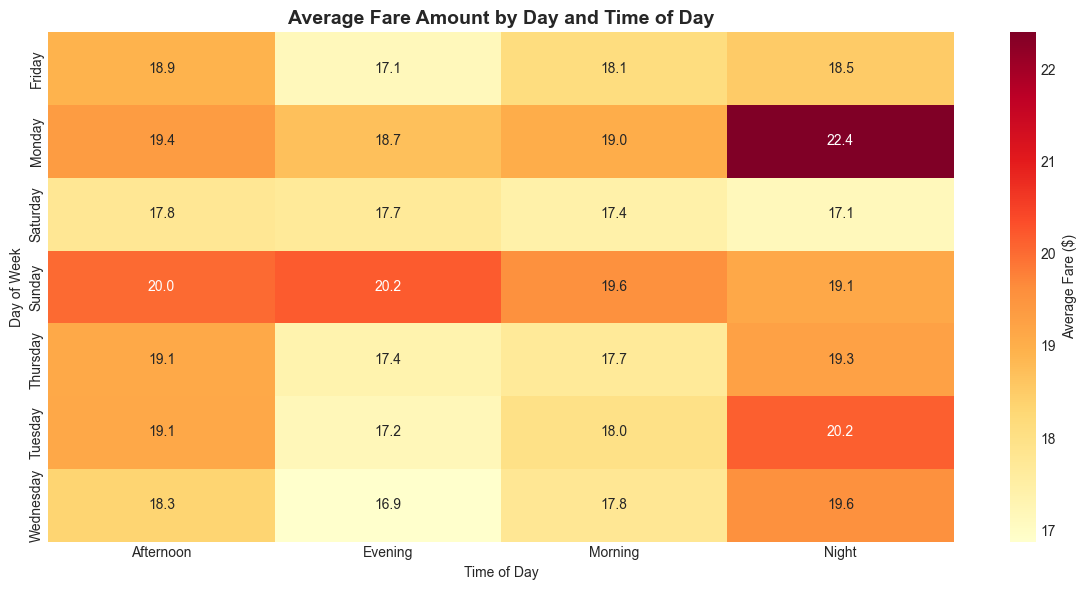

In [5]:
# Create a pivot table: Average fare by day of week and time of day
pivot_fare = df_ts.pivot_table(
    values='fare_amount',
    index='day_name',
    columns='time_of_day',
    aggfunc='mean'
)

display(Markdown("### 📊 Average Fare by Day of Week and Time of Day"))
display(Markdown(pivot_fare.round(2).to_markdown()))

# Visualize the pivot table
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_fare, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Average Fare ($)'})
plt.title('Average Fare Amount by Day and Time of Day', fontsize=14, fontweight='bold')
plt.xlabel('Time of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

### Step 6: Reshape Data - Melt Example

In [6]:
# Example: Convert wide format to long format
# Let's create a summary by hour with multiple metrics

hourly_summary = df_ts.groupby('hour').agg({
    'fare_amount': 'mean',
    'trip_distance': 'mean',
    'trip_duration': 'mean',
    'passenger_count': 'mean'
}).reset_index()

display(Markdown("### 📋 Hourly Summary (Wide Format)"))
display(Markdown(hourly_summary.head().round(2).to_markdown(index=False)))

# Melt to long format
hourly_long = hourly_summary.melt(
    id_vars='hour',
    value_vars=['fare_amount', 'trip_distance', 'trip_duration', 'passenger_count'],
    var_name='metric',
    value_name='value'
)

display(Markdown("### 📋 Hourly Summary (Long Format)"))
display(Markdown(hourly_long.head(10).round(2).to_markdown(index=False)))

### 📋 Hourly Summary (Wide Format)

|   hour |   fare_amount |   trip_distance |   trip_duration |   passenger_count |
|-------:|--------------:|----------------:|----------------:|------------------:|
|      0 |         19.77 |            4.03 |           13.44 |              1.44 |
|      1 |         17.81 |            3.5  |           12.47 |              1.46 |
|      2 |         16.71 |            3.22 |           11.85 |              1.46 |
|      3 |         17.71 |            3.51 |           11.92 |              1.44 |
|      4 |         22.23 |            4.68 |           13.24 |              1.41 |

### 📋 Hourly Summary (Long Format)

|   hour | metric      |   value |
|-------:|:------------|--------:|
|      0 | fare_amount |   19.77 |
|      1 | fare_amount |   17.81 |
|      2 | fare_amount |   16.71 |
|      3 | fare_amount |   17.71 |
|      4 | fare_amount |   22.23 |
|      5 | fare_amount |   26.39 |
|      6 | fare_amount |   22.11 |
|      7 | fare_amount |   18.89 |
|      8 | fare_amount |   17.4  |
|      9 | fare_amount |   17.59 |

---

## Phase 5: Feature Engineering & Aggregation

### Learning Objectives

- Create derived features
- Perform groupby aggregations
- Calculate rolling window statistics
- Create time-based features
- Aggregate by multiple dimensions

### Step 1: Create Derived Features

In [7]:
# Feature engineering constants
MINUTES_PER_HOUR = 60
MAX_REASONABLE_SPEED_MPH = 60  # Highway speed limit in NYC area

# Speed (miles per hour) - derived from distance and duration
duration_hours = df_ts['trip_duration'] / MINUTES_PER_HOUR
df_ts['speed_mph'] = df_ts['trip_distance'] / duration_hours
df_ts['speed_mph'] = df_ts['speed_mph'].replace([np.inf, -np.inf], np.nan)  # Handle division by zero
df_ts['speed_mph'] = df_ts['speed_mph'].clip(upper=MAX_REASONABLE_SPEED_MPH)

# Fare per mile
df_ts['fare_per_mile'] = df_ts['fare_amount'] / df_ts['trip_distance']
df_ts['fare_per_mile'] = df_ts['fare_per_mile'].replace([np.inf, -np.inf], np.nan)

# Tip percentage
df_ts['tip_percentage'] = (df_ts['tip_amount'] / df_ts['fare_amount']) * 100
df_ts['tip_percentage'] = df_ts['tip_percentage'].fillna(0)  # No tip = 0%

# Distance category thresholds (miles) - based on typical NYC trip patterns
SHORT_TRIP_MAX = 1.0   # Neighborhood trips, often walkable
MEDIUM_TRIP_MAX = 3.0  # Cross-neighborhood, typical taxi trip
LONG_TRIP_MAX = 10.0   # Cross-borough, airport trips

def categorize_distance(dist):
    """
    Categorize trip distance based on NYC geography.

    - Short (<1 mi): Within neighborhood
    - Medium (1-3 mi): Cross-neighborhood, typical taxi trip
    - Long (3-10 mi): Cross-borough, airport trips
    - Very Long (>10 mi): Outer borough/suburbs
    """
    if dist < SHORT_TRIP_MAX:
        return 'Short'
    elif dist < MEDIUM_TRIP_MAX:
        return 'Medium'
    elif dist < LONG_TRIP_MAX:
        return 'Long'
    else:
        return 'Very Long'

df_ts['distance_category'] = df_ts['trip_distance'].apply(categorize_distance)

display(Markdown("### ✨ Derived Features Created"))
display(Markdown(df_ts[['speed_mph', 'fare_per_mile', 'tip_percentage', 'distance_category']].head(10).round(2).to_markdown()))

### ✨ Derived Features Created

| pickup_datetime     |   speed_mph |   fare_per_mile |   tip_percentage | distance_category   |
|:--------------------|------------:|----------------:|-----------------:|:--------------------|
| 2022-10-25 00:42:10 |       26.45 |            4.64 |             0    | Short               |
| 2022-10-25 00:59:02 |       13.98 |            4.29 |             0    | Medium              |
| 2022-10-25 03:45:46 |       18    |         5750    |             4.35 | Short               |
| 2022-10-25 07:48:15 |       60    |          102.63 |            20.21 | Short               |
| 2022-10-25 09:06:23 |       25.55 |            3.01 |             0    | Long                |
| 2022-10-25 13:03:37 |       60    |          281.82 |            25.32 | Short               |
| 2022-12-31 14:24:54 |        2.34 |           24.39 |             0    | Short               |
| 2022-12-31 14:39:43 |        8.31 |           10.74 |            37.24 | Short               |
| 2022-12-31 15:14:12 |        8.13 |            6.95 |             0    | Medium              |
| 2022-12-31 22:02:51 |       18.19 |            4.61 |            22.79 | Long                |

### Step 2: GroupBy Aggregations

**What is GroupBy?**
GroupBy splits data into groups, applies a function to each group, and combines the results. It's one of pandas' most powerful features for data analysis.

**Why use GroupBy?**

- **Summarize:** Calculate statistics for each group (e.g., average fare by day of week)
- **Compare:** See how metrics differ across groups
- **Aggregate:** Reduce data size while preserving important patterns
- **Explore:** Discover relationships between categorical and numeric variables

**Common GroupBy operations:**

- **Single column:** `groupby('day_of_week')` - group by one variable
- **Multiple columns:** `groupby(['day_of_week', 'time_of_day'])` - group by multiple variables
- **Multiple functions:** `agg({'fare': 'mean', 'distance': 'sum'})` - different functions for different columns

In [8]:
# Aggregate by day of week
daily_stats = df_ts.groupby('day_name').agg({
    'fare_amount': ['mean', 'median', 'std', 'count'],
    'trip_distance': ['mean', 'median'],
    'trip_duration': ['mean', 'median'],
    'passenger_count': 'mean'
}).round(2)

# Flatten multi-level column names for cleaner display
daily_stats.columns = ['_'.join(col).strip() for col in daily_stats.columns.values]
display(Markdown("### 📅 Statistics by Day of Week"))
display(Markdown(daily_stats.to_markdown()))

# Aggregate by multiple dimensions: day of week and time of day
multi_agg = df_ts.groupby(['day_name', 'time_of_day']).agg({
    'fare_amount': 'mean',
    'trip_distance': 'count'  # Count of trips
}).rename(columns={'fare_amount': 'avg_fare', 'trip_distance': 'trip_count'}).round(2)

display(Markdown("### 📊 Average Fare by Day and Time"))
display(Markdown(multi_agg.head(15).to_markdown()))

### 📅 Statistics by Day of Week

| day_name   |   fare_amount_mean |   fare_amount_median |   fare_amount_std |   fare_amount_count |   trip_distance_mean |   trip_distance_median |   trip_duration_mean |   trip_duration_median |   passenger_count_mean |
|:-----------|-------------------:|---------------------:|------------------:|--------------------:|---------------------:|-----------------------:|---------------------:|-----------------------:|-----------------------:|
| Friday     |              18.19 |                 12.8 |             16.39 |              408497 |                 3.29 |                   1.76 |                14.84 |                  11.72 |                   1.39 |
| Monday     |              19.58 |                 12.8 |             18.93 |              379756 |                 3.82 |                   1.84 |                14.31 |                  11.02 |                   1.37 |
| Saturday   |              17.5  |                 12.8 |             15.35 |              415922 |                 3.16 |                   1.81 |                13.76 |                  11.33 |                   1.48 |
| Sunday     |              19.7  |                 12.8 |             18.49 |              407619 |                 3.89 |                   2    |                13.83 |                  11.07 |                   1.47 |
| Thursday   |              18.31 |                 12.8 |             16.39 |              414441 |                 3.25 |                   1.74 |                15.25 |                  12.12 |                   1.34 |
| Tuesday    |              18.46 |                 12.8 |             16.81 |              461714 |                 3.34 |                   1.75 |                14.84 |                  11.72 |                   1.33 |
| Wednesday  |              17.99 |                 12.8 |             16.13 |              391455 |                 3.22 |                   1.73 |                14.63 |                  11.73 |                   1.33 |

### 📊 Average Fare by Day and Time

|                           |   avg_fare |   trip_count |
|:--------------------------|-----------:|-------------:|
| ('Friday', 'Afternoon')   |      18.94 |       119560 |
| ('Friday', 'Evening')     |      17.15 |       106879 |
| ('Friday', 'Morning')     |      18.11 |        90421 |
| ('Friday', 'Night')       |      18.51 |        91637 |
| ('Monday', 'Afternoon')   |      19.38 |       126061 |
| ('Monday', 'Evening')     |      18.7  |        99557 |
| ('Monday', 'Morning')     |      19.04 |        95720 |
| ('Monday', 'Night')       |      22.4  |        58418 |
| ('Saturday', 'Afternoon') |      17.77 |       121913 |
| ('Saturday', 'Evening')   |      17.69 |       100487 |
| ('Saturday', 'Morning')   |      17.43 |        65026 |
| ('Saturday', 'Night')     |      17.15 |       128496 |
| ('Sunday', 'Afternoon')   |      20.01 |       127508 |
| ('Sunday', 'Evening')     |      20.19 |        86515 |
| ('Sunday', 'Morning')     |      19.56 |        68024 |

### Step 3: Rolling Window Calculations

**What are rolling windows?**
Rolling windows calculate statistics over a sliding window of time periods. For example, a 7-day rolling mean calculates the average of the current day and the previous 6 days.

**Why use rolling windows?**

- **Smooth trends:** Remove daily noise to see underlying patterns
- **Moving averages:** Common in time series analysis
- **Trend detection:** Identify increasing/decreasing trends
- **Anomaly detection:** Compare current values to rolling statistics

**Common rolling window operations:**

- **Rolling mean:** Average over window (smooths data)
- **Rolling median:** Median over window (robust to outliers)
- **Rolling std:** Standard deviation over window (measures volatility)
- **Rolling min/max:** Min/max over window (identifies extremes)

**Window size considerations:**

- **Small windows (3-7 days):** Capture short-term patterns, more responsive to changes
- **Large windows (30+ days):** Capture long-term trends, smoother but less responsive

### 📈 Rolling Window Calculations

| pickup_datetime     |   fare_amount |   fare_7d_avg |   fare_30d_avg |   fare_ewm |
|:--------------------|--------------:|--------------:|---------------:|-----------:|
| 2022-10-25 00:00:00 |          7.25 |          7.25 |           7.25 |       7.25 |
| 2022-10-25 01:00:00 |        nan    |          7.25 |           7.25 |       7.25 |
| 2022-10-25 02:00:00 |        nan    |          7.25 |           7.25 |       7.25 |
| 2022-10-25 03:00:00 |        115    |         61.12 |          61.12 |       8.56 |
| 2022-10-25 04:00:00 |        nan    |         61.12 |          61.12 |       8.56 |
| 2022-10-25 05:00:00 |        nan    |         61.12 |          61.12 |       8.56 |
| 2022-10-25 06:00:00 |        nan    |         61.12 |          61.12 |       8.56 |
| 2022-10-25 07:00:00 |         78    |         66.75 |          66.75 |       9.41 |
| 2022-10-25 08:00:00 |        nan    |         66.75 |          66.75 |       9.41 |
| 2022-10-25 09:00:00 |         19.5  |         54.94 |          54.94 |       9.53 |
| 2022-10-25 10:00:00 |        nan    |         54.94 |          54.94 |       9.53 |
| 2022-10-25 11:00:00 |        nan    |         54.94 |          54.94 |       9.53 |
| 2022-10-25 12:00:00 |        nan    |         54.94 |          54.94 |       9.53 |
| 2022-10-25 13:00:00 |         62    |         56.35 |          56.35 |      10.17 |
| 2022-10-25 14:00:00 |        nan    |         56.35 |          56.35 |      10.17 |
| 2022-10-25 15:00:00 |        nan    |         56.35 |          56.35 |      10.17 |
| 2022-10-25 16:00:00 |        nan    |         56.35 |          56.35 |      10.17 |
| 2022-10-25 17:00:00 |        nan    |         56.35 |          56.35 |      10.17 |
| 2022-10-25 18:00:00 |        nan    |         56.35 |          56.35 |      10.17 |
| 2022-10-25 19:00:00 |        nan    |         56.35 |          56.35 |      10.17 |

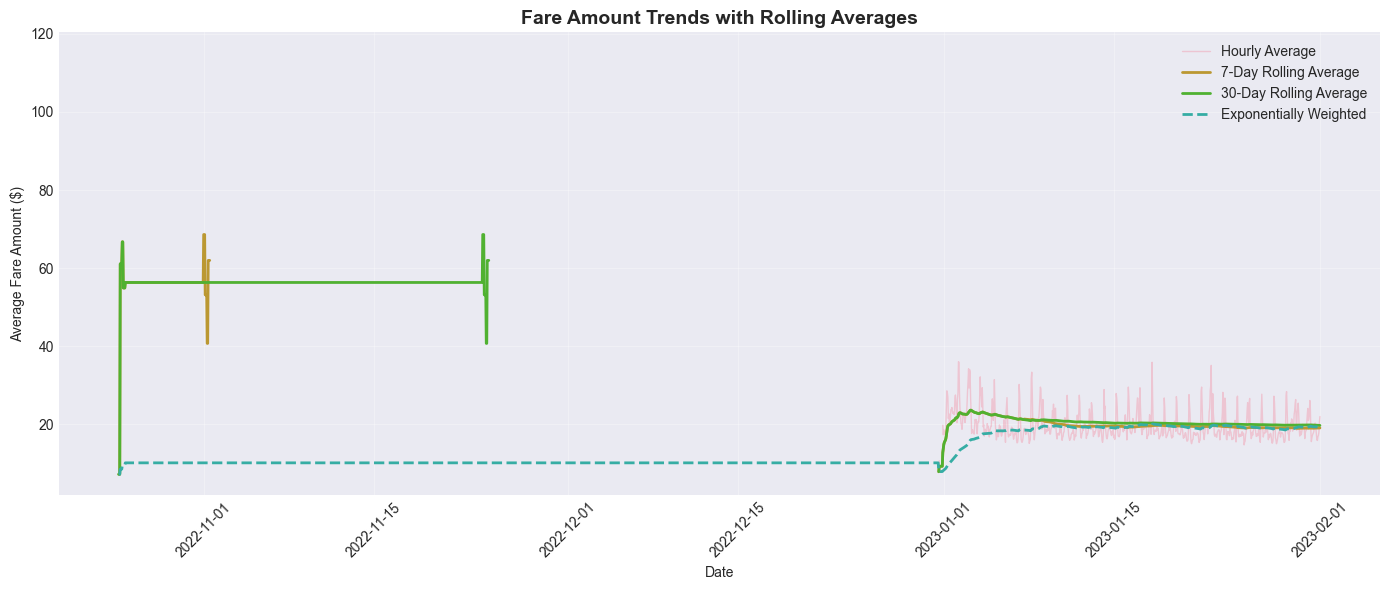

In [9]:
# Resample to hourly for rolling calculations
hourly_trips = df_ts.resample('h').agg({
    'fare_amount': ['mean', 'count'],
    'trip_distance': 'mean',
    'total_amount': 'sum'
})
hourly_trips.columns = ['fare_amount', 'trip_count', 'trip_distance', 'total_amount']
hourly_trips = hourly_trips[['fare_amount', 'trip_distance', 'total_amount', 'trip_count']]

# Rolling window parameters (in hours, since we're using hourly data)
SHORT_WINDOW_DAYS = 7   # Weekly pattern detection
LONG_WINDOW_DAYS = 30   # Monthly trend detection
HOURS_PER_DAY = 24

SHORT_WINDOW_HOURS = SHORT_WINDOW_DAYS * HOURS_PER_DAY  # 168 hours
LONG_WINDOW_HOURS = LONG_WINDOW_DAYS * HOURS_PER_DAY    # 720 hours

# Calculate rolling averages
hourly_trips['fare_7d_avg'] = hourly_trips['fare_amount'].rolling(
    window=SHORT_WINDOW_HOURS,
    min_periods=1
).mean()

hourly_trips['fare_30d_avg'] = hourly_trips['fare_amount'].rolling(
    window=LONG_WINDOW_HOURS,
    min_periods=1
).mean()

# Exponentially weighted moving average (gives more weight to recent data)
hourly_trips['fare_ewm'] = hourly_trips['fare_amount'].ewm(
    span=SHORT_WINDOW_HOURS,
    adjust=False  # Use recursive calculation
).mean()

display(Markdown("### 📈 Rolling Window Calculations"))
display(Markdown(hourly_trips[['fare_amount', 'fare_7d_avg', 'fare_30d_avg', 'fare_ewm']].head(20).round(2).to_markdown()))

# Visualize rolling averages
plt.figure(figsize=(14, 6))
plt.plot(hourly_trips.index, hourly_trips['fare_amount'], alpha=0.3, label='Hourly Average', linewidth=1)
plt.plot(hourly_trips.index, hourly_trips['fare_7d_avg'], label='7-Day Rolling Average', linewidth=2)
plt.plot(hourly_trips.index, hourly_trips['fare_30d_avg'], label='30-Day Rolling Average', linewidth=2)
plt.plot(hourly_trips.index, hourly_trips['fare_ewm'], label='Exponentially Weighted', linewidth=2, linestyle='--')
plt.title('Fare Amount Trends with Rolling Averages', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Average Fare Amount ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 4: Time-Based Aggregations

### ⏰ Hourly Patterns (aggregated across all days)

|   hour |   fare_amount |   trip_count |   trip_distance |     total_amount |
|-------:|--------------:|-------------:|----------------:|-----------------:|
|      0 |         19.77 |        79378 |            4.03 |      1.89094e+06 |
|      1 |         17.81 |        55427 |            3.5  |      1.19584e+06 |
|      2 |         16.71 |        38632 |            3.22 | 781076           |
|      3 |         17.71 |        24975 |            3.51 | 531463           |
|      4 |         22.23 |        15777 |            4.68 | 413250           |
|      5 |         26.39 |        16100 |            5.97 | 495421           |
|      6 |         22.11 |        39890 |            4.77 |      1.0403e+06  |
|      7 |         18.89 |        79451 |            3.67 |      1.79852e+06 |
|      8 |         17.4  |       107728 |            3.07 |      2.26659e+06 |
|      9 |         17.59 |       122462 |            3.09 |      2.60504e+06 |

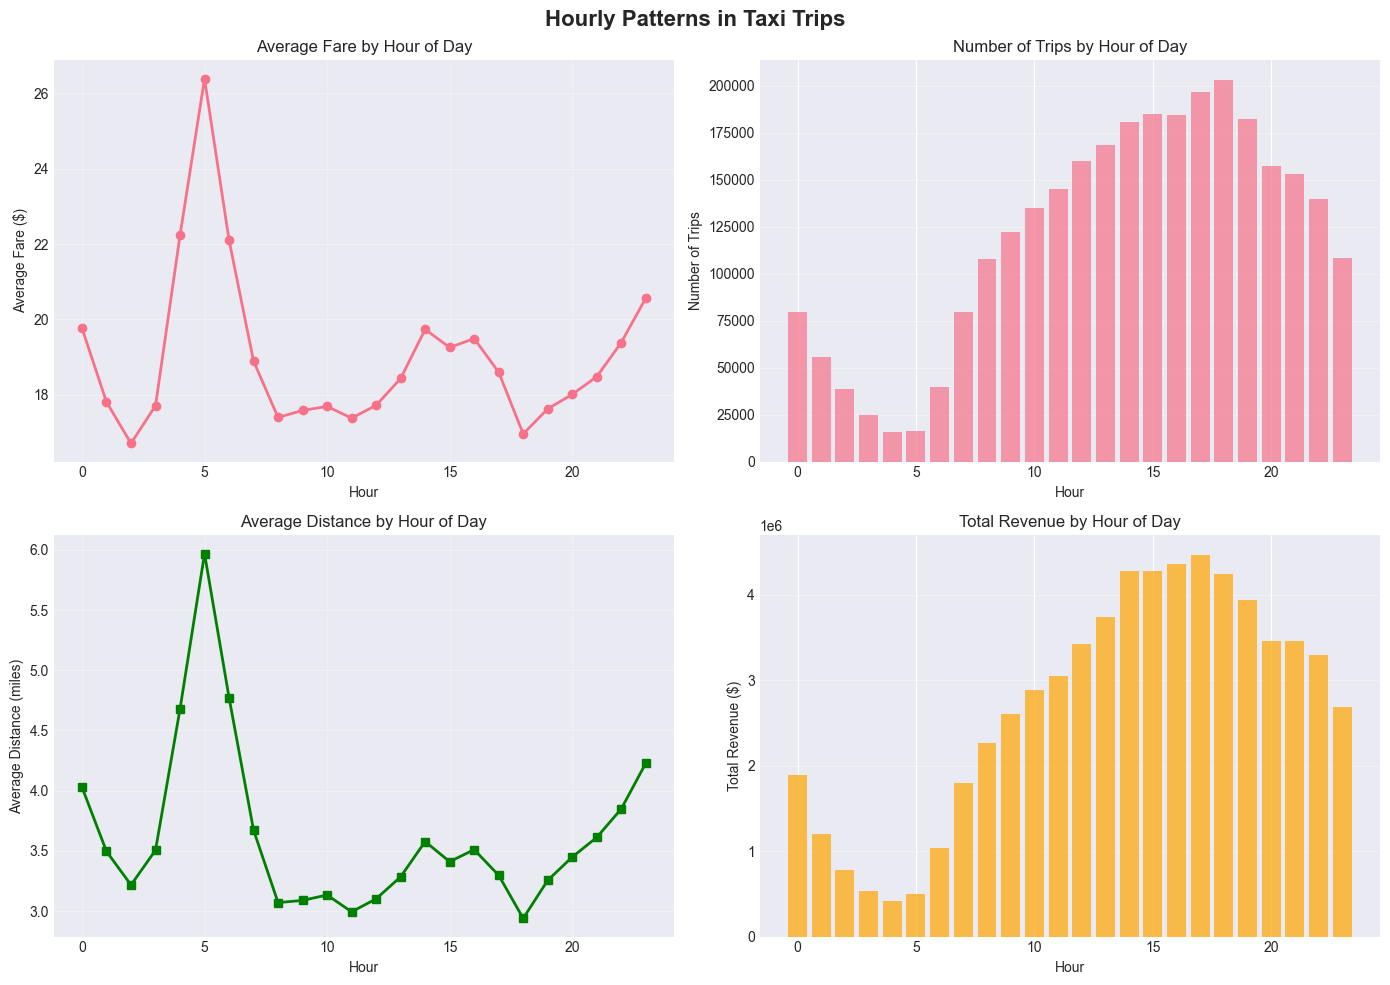

In [10]:
# Aggregate by hour of day (across all days)
hourly_pattern = df_ts.groupby('hour').agg({
    'fare_amount': ['mean', 'count'],
    'trip_distance': 'mean',
    'total_amount': 'sum'
})
hourly_pattern.columns = ['fare_amount', 'trip_count', 'trip_distance', 'total_amount']
hourly_pattern = hourly_pattern[['fare_amount', 'trip_count', 'trip_distance', 'total_amount']]

display(Markdown("### ⏰ Hourly Patterns (aggregated across all days)"))
display(Markdown(hourly_pattern.head(10).round(2).to_markdown()))

# Visualize hourly patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Hourly Patterns in Taxi Trips', fontsize=16, fontweight='bold')

# Average fare by hour
axes[0, 0].plot(hourly_pattern.index, hourly_pattern['fare_amount'], marker='o', linewidth=2)
axes[0, 0].set_title('Average Fare by Hour of Day')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Average Fare ($)')
axes[0, 0].grid(True, alpha=0.3)

# Trip count by hour
axes[0, 1].bar(hourly_pattern.index, hourly_pattern['trip_count'], alpha=0.7)
axes[0, 1].set_title('Number of Trips by Hour of Day')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Number of Trips')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Average distance by hour
axes[1, 0].plot(hourly_pattern.index, hourly_pattern['trip_distance'], marker='s', color='green', linewidth=2)
axes[1, 0].set_title('Average Distance by Hour of Day')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Average Distance (miles)')
axes[1, 0].grid(True, alpha=0.3)

# Total revenue by hour
axes[1, 1].bar(hourly_pattern.index, hourly_pattern['total_amount'], alpha=0.7, color='orange')
axes[1, 1].set_title('Total Revenue by Hour of Day')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Total Revenue ($)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Step 5: Cross-Tabulation

In [11]:
# Cross-tabulation: Day of week vs Time of day
crosstab = pd.crosstab(
    df_ts['day_name'],
    df_ts['time_of_day'],
    margins=True
)

display(Markdown("### 📊 Trip Count: Day of Week × Time of Day"))
display(Markdown(crosstab.to_markdown()))

# Cross-tabulation with aggregation
crosstab_fare = pd.crosstab(
    df_ts['day_name'],
    df_ts['time_of_day'],
    values=df_ts['fare_amount'],
    aggfunc='mean',
    margins=True
).round(2)

display(Markdown("### 💵 Average Fare: Day of Week × Time of Day"))
display(Markdown(crosstab_fare.to_markdown()))

### 📊 Trip Count: Day of Week × Time of Day

| day_name   |   Afternoon |   Evening |   Morning |   Night |             All |
|:-----------|------------:|----------:|----------:|--------:|----------------:|
| Friday     |      119560 |    106879 |     90421 |   91637 | 408497          |
| Monday     |      126061 |     99557 |     95720 |   58418 | 379756          |
| Saturday   |      121913 |    100487 |     65026 |  128496 | 415922          |
| Sunday     |      127508 |     86515 |     68024 |  125572 | 407619          |
| Thursday   |      122968 |    113186 |    102669 |   75618 | 414441          |
| Tuesday    |      141350 |    123501 |    125564 |   71299 | 461714          |
| Wednesday  |      119243 |    109659 |     98353 |   64200 | 391455          |
| All        |      878603 |    739784 |    645777 |  615240 |      2.8794e+06 |

### 💵 Average Fare: Day of Week × Time of Day

| day_name   |   Afternoon |   Evening |   Morning |   Night |   All |
|:-----------|------------:|----------:|----------:|--------:|------:|
| Friday     |       18.94 |     17.15 |     18.11 |   18.51 | 18.19 |
| Monday     |       19.38 |     18.7  |     19.04 |   22.4  | 19.58 |
| Saturday   |       17.77 |     17.69 |     17.43 |   17.15 | 17.5  |
| Sunday     |       20.01 |     20.19 |     19.56 |   19.13 | 19.7  |
| Thursday   |       19.12 |     17.37 |     17.68 |   19.26 | 18.31 |
| Tuesday    |       19.12 |     17.19 |     18    |   20.15 | 18.46 |
| Wednesday  |       18.34 |     16.88 |     17.78 |   19.56 | 17.99 |
| All        |       18.97 |     17.79 |     18.19 |   19.11 | 18.52 |

### Step 6: Save Processed Data

In [12]:
# Reset index to make pickup_datetime a regular column again
df_processed = df_ts.reset_index()

# Save processed dataset for next notebook
df_processed.to_csv('../output/02_processed_taxi_data.csv', index=False)

display(Markdown(f"""
### 💾 Data Saved Successfully

| Metric | Value |
|--------|-------|
| **Trips saved** | {len(df_processed):,} |
| **Total columns** | {df_processed.shape[1]} |
| **Output file** | `../output/02_processed_taxi_data.csv` |

✅ **Ready for next phase: Pattern Analysis & Modeling Prep!**
"""))


### 💾 Data Saved Successfully

| Metric | Value |
|--------|-------|
| **Trips saved** | 2,879,404 |
| **Total columns** | 37 |
| **Output file** | `../output/02_processed_taxi_data.csv` |

✅ **Ready for next phase: Pattern Analysis & Modeling Prep!**


---

## Summary

**What we accomplished:**

1. ✅ **Set datetime index** for time-based operations
2. ✅ **Extracted time-based features** (hour, day, month, etc.)
3. ✅ **Merged zone lookup data** using pandas merge
4. ✅ **Reshaped data** using pivot and melt
5. ✅ **Created derived features** (speed, fare per mile, etc.)
6. ✅ **Performed aggregations** by multiple dimensions
7. ✅ **Calculated rolling windows** for trend analysis
8. ✅ **Created time-based patterns** and visualizations

**Key Takeaways:**

- Datetime indexing enables time-based operations and aggregations
- Merging enriches data with additional context
- Feature engineering creates predictive signals
- Rolling windows reveal trends and patterns
- GroupBy aggregations summarize data at different levels

**Next:** Notebook 3 will focus on pattern analysis, advanced visualizations, and preparing data for modeling.